# Example 4: Classification

## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

create the two moon dataset

cuda


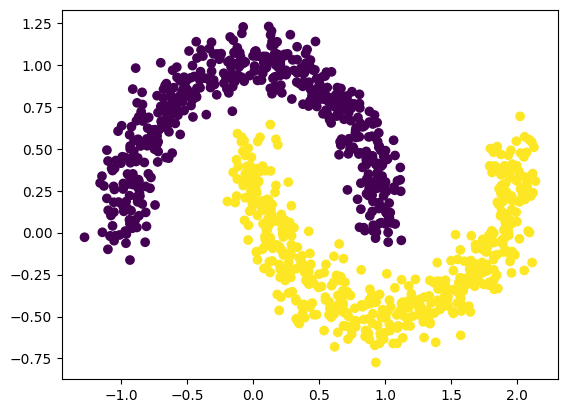

In [1]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

Train KAN

In [2]:
model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

num 3
grid.shape torch.Size([2, 4])
grid.shape data tensor([[-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000]])
grid.shape extended torch.Size([2, 10])
grid.shape extended data tensor([[-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000],
        [-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000]])
noises.shape torch.Size([4, 2, 1])
self.coef.shape torch.Size([2, 1, 6])
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 1.66e-01 | test_loss: 1.70e-01 | reg: 3.86e+00 | : 100%|█| 20/20 [00:07<00:00,  2.75it

saving model version 0.1


(0.999000072479248, 0.999000072479248)

Automatic symbolic regression

In [3]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.965124785900116, c=2
fixing (0,1,0) with x, r2=0.9911245107650757, c=1
saving model version 0.2


-0.8158*x_2 - 0.3562*sin(3.2278*x_1 - 8.0218) + 0.7038

How accurate is this formula?

In [4]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9980, device='cuda:0')
test acc of the formula: tensor(0.9980, device='cuda:0')


## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

torch.Size([1000, 2])
torch.Size([1000])


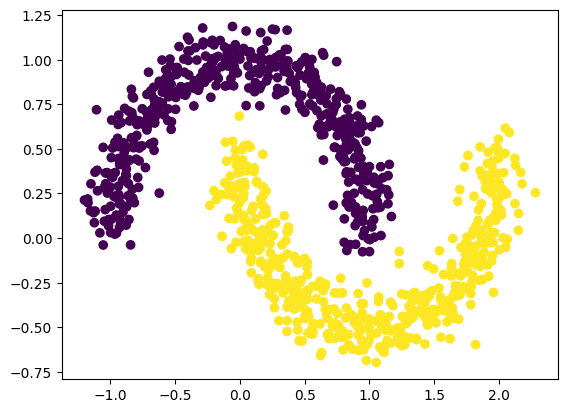

In [5]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

print(dataset['train_input'].shape)
print(dataset['train_label'].shape)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

In [6]:
dataset['train_label']

tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,

### Train KAN

In [7]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args_dict = {
    'grid': 3,
    #'grid': 10,
    'k': 3,
    'seed': 2024,
    'sp_trainable': True,
    'sb_trainable': True,
    'affine_trainable': True,
    #'base_fun': ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs'],
    #'spline_noise_scale': 0.1,
    'mode': 'default',
    'init_mode': 'default',
    #'init_mode': 'xavier_in_out',
}
args = Args(**args_dict)

model = KAN(
    width=[2,3,4,3,2], 
    device=device,
    #width=width, device=device,
    grid=args.grid, k=args.k, seed=args.seed,
    sp_trainable=args.sp_trainable, sb_trainable=args.sb_trainable, affine_trainable=args.affine_trainable,
    #base_fun=args.base_fun,
    #noise_scale=args.spline_noise_scale,
    mode=args.mode,
    init_mode=args.init_mode,
    #ckpt_path=ckpt_folder
    )

num 3
grid.shape torch.Size([2, 4])
grid.shape data tensor([[-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000]])
grid.shape extended torch.Size([2, 10])
grid.shape extended data tensor([[-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000],
        [-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000]])
noises.shape torch.Size([4, 2, 3])
self.coef.shape torch.Size([2, 3, 6])
num 3
grid.shape torch.Size([3, 4])
grid.shape data tensor([[-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000]])
grid.shape extended torch.Size([3, 10])
grid.shape extended data tensor([[-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000],
        [-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000],
        [-3.0000, -2.333

In [8]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(
    dataset, 
    opt="LBFGS", 
    steps=20, 
    metrics=(train_acc, test_acc), 
    loss_fn=torch.nn.CrossEntropyLoss()
    );

| train_loss: 7.22e-02 | test_loss: 1.75e-01 | reg: 2.51e+01 | : 100%|█| 20/20 [00:16<00:00,  1.22it

saving model version 0.1


Automatic symbolic regression

In [9]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
# model.auto_symbolic(lib=lib)

In [10]:
# formula1, formula2 = model.symbolic_formula()[0]
# ex_round(formula1, 4)

In [11]:
# ex_round(formula2, 4)

How accurate is this formula?

In [12]:
# # how accurate is this formula?
# def acc(formula1, formula2, X, y):
#     batch = X.shape[0]
#     correct = 0
#     for i in range(batch):
#         logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
#         logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
#         correct += (logit2 > logit1) == y[i]
#     return correct/batch

# print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
# print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

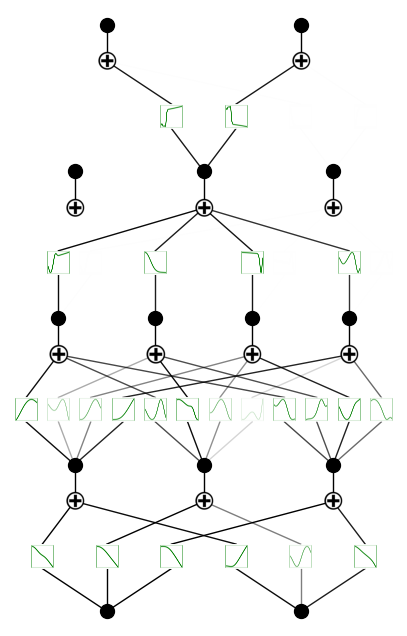

In [13]:
model.plot()

act (1000, 3, 2)
act sum (1000, 3, 1)
act (1000, 4, 3)
act sum (1000, 4, 1)
act (1000, 3, 4)
act sum (1000, 3, 1)
act (1000, 2, 3)
act sum (1000, 2, 1)


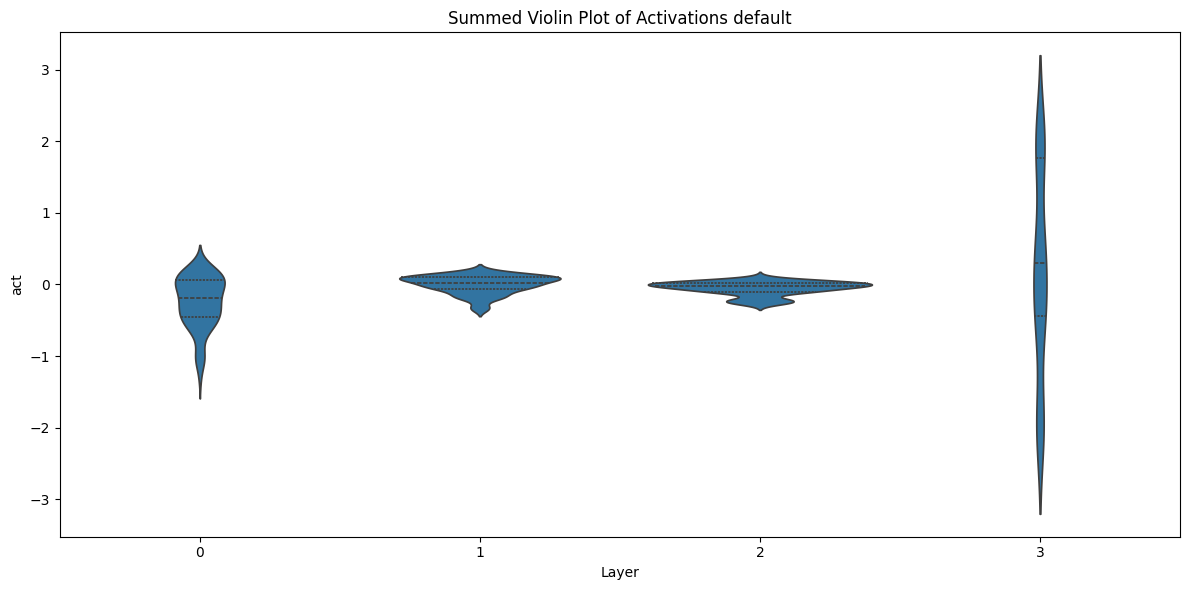

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_summed_violins(model, title, mode="act", sample_size=100):
    data = []
    for layer_index, (act_fun, acts, preacts, postacts, postsplines) in enumerate(zip(model.act_fun, model.acts, model.spline_preacts, model.spline_postacts, model.spline_postsplines)):
        
        coef = act_fun.coef

        dist_np = None  # Changed from acts_np to dist_np
        if mode == "coef":
            dist_np = coef.cpu().detach().numpy()
            print("act", dist_np.shape)
            dist_np = dist_np.sum(axis=2, keepdims=True)    
            print("act sum",dist_np.shape)
        elif mode == "act":
            dist_np = postacts.cpu().detach().numpy()
            print("act", dist_np.shape)
            dist_np = dist_np.sum(axis=2, keepdims=True)    
            print("act sum",dist_np.shape)
        elif mode == "grad":
            dist_np = coef.grad.cpu().detach().numpy()




        # Ensure dist_np is a 1D array
        dist_np = dist_np.flatten()

        # Sample a subset of activations if there are more than sample_size
        if len(dist_np) > sample_size:
            sampled_acts = np.random.choice(dist_np, sample_size, replace=False)
        else:
            sampled_acts = dist_np  # Use all if less than sample_size
        
        # Append layer index and sampled activations to the data list
        data.extend([(layer_index, act) for act in sampled_acts])

    # Convert the data into a DataFrame
    df = pd.DataFrame(data, columns=['Layer', 'Activation'])

    plt.figure(figsize=(12, 6))

    # Create a violin plot
    sns.violinplot(data=df, x="Layer", y="Activation", inner="quart")

    # Adding labels and title
    plt.title(title)
    plt.xlabel('Layer')
    plt.ylabel(f'{mode}')
    plt.tight_layout()

    # Show plot
    plt.show()
    return plt.gcf()

title = f"Summed Violin Plot of Activations {args.init_mode}"
plot_summed_violins(model, title, mode="act", sample_size=100)

act (2, 3, 6)
act sum (2, 3, 1)
act (3, 4, 6)
act sum (3, 4, 1)
act (4, 3, 6)
act sum (4, 3, 1)
act (3, 2, 6)
act sum (3, 2, 1)


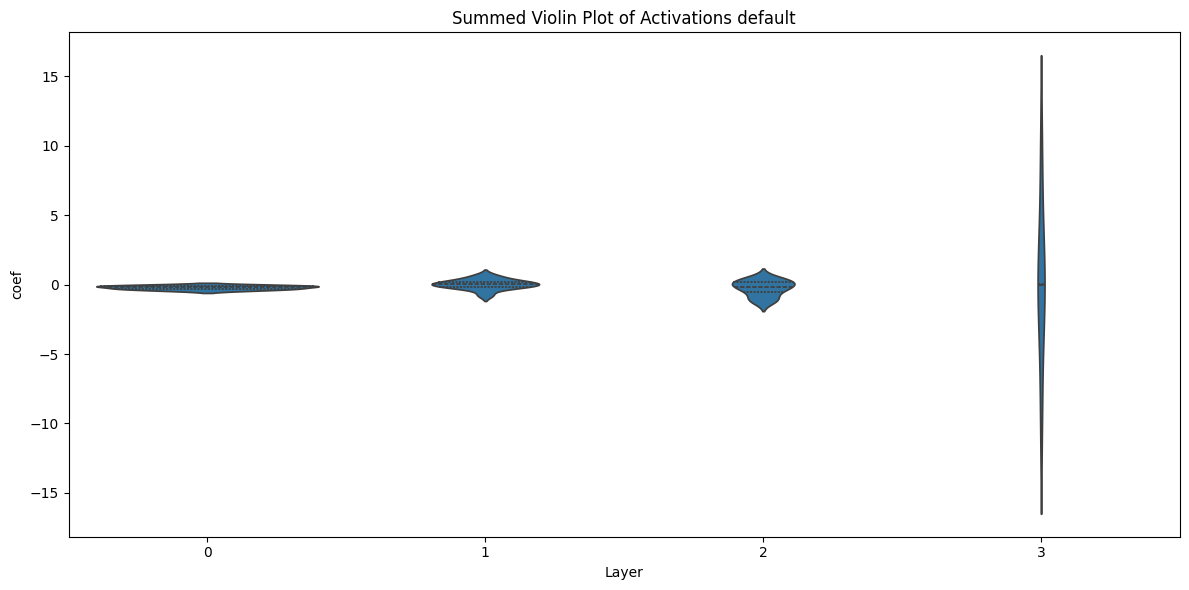

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
title = f"Summed Violin Plot of Activations {args.init_mode}"
plot_summed_violins(model, title, mode="coef", sample_size=100)

act (2, 3, 6)
act sum (2, 3, 1)
act (3, 4, 6)
act sum (3, 4, 1)
act (4, 3, 6)
act sum (4, 3, 1)
act (3, 2, 6)
act sum (3, 2, 1)


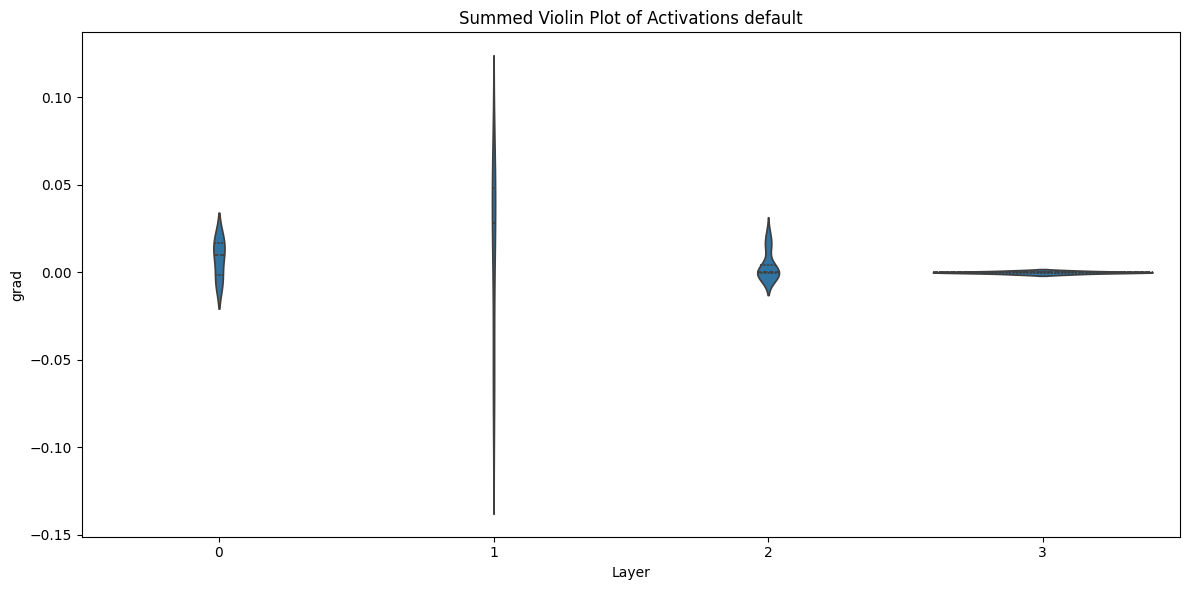

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
title = f"Summed Violin Plot of Activations {args.init_mode}"
plot_summed_violins(model, title, mode="grad", sample_size=100)